## Import Libraries

In [1]:
!pip install textblob
!pip install nltk
!pip install mysql-connector-python

In [2]:
import os
import re
import calendar
import pandas as pd
import numpy as np
import networkx as nx
import nltk
import matplotlib.pylab as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

## Load the dataset

In [3]:
reviews_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [4]:
reviews_df.shape

(23486, 11)

In [5]:
reviews_df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [7]:
reviews_df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [8]:
review_df = reviews_df.rename(columns = {'Clothing ID': 'Clothing_ID', 'Review Text': 'Review_Text', 'Recommended IND': 'Recommended_IND', 'Positive Feedback Count': 'Positive_Feedback_Count', 'Division Name': 'Division_Name', 'Department Name': 'Department_Name', 'Class Name': 'Class_Name'})

In [9]:
review_df.head()

,Unnamed: 0,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Exploratory Data Analysis (EDA)

In [10]:
review_df.isnull().sum()

Unnamed: 0                    0
Clothing_ID                   0
Age                           0
Title                      3810
Review_Text                 845
Rating                        0
Recommended_IND               0
Positive_Feedback_Count       0
Division_Name                14
Department_Name              14
Class_Name                   14
dtype: int64

In [11]:
review_df = review_df.dropna(subset=['Review_Text'])

In [12]:
review_df['Review_Text'].isna().sum()

np.int64(0)

In [13]:
review_df.shape

(22641, 11)

#### Extract the following information: Review text and Review rating to reviews_for_export.csv reviews_for_export.csv is loaded to MySQL and saved in a table extracted_reviews

In [14]:
df_subset1 = review_df[['Review_Text', 'Rating']].copy()

output_file_name = 'reviews_for_export.csv'
df_subset1.to_csv(output_file_name, index=False)

print(f"\nData successfully saved to {output_file_name}")


Data successfully saved to reviews_for_export.csv


## Text Pre-Processing

### Converting all characters into lowercase

In [15]:
# Creating a new collumn named Clean_Text, so that we can keep the original column Review_Text. Converting the text to lowercase.
review_df['Clean_Text'] = review_df['Review_Text'].str.lower()

review_df[['Clean_Text']].head(10)

,Clean_Text
0,absolutely wonderful - silky and sexy and comf...
1,love this dress! it's sooo pretty. i happene...
2,i had such high hopes for this dress and reall...
3,"i love, love, love this jumpsuit. it's fun, fl..."
4,this shirt is very flattering to all due to th...
5,"i love tracy reese dresses, but this one is no..."
6,i aded this in my basket at hte last mintue to...
7,"i ordered this in carbon for store pick up, an..."
8,i love this dress. i usually get an xs but it ...
9,"i'm 5""5' and 125 lbs. i ordered the s petite t..."


### Removing URL

In [16]:
def removeURL(text):
    return re.sub(r'http\S+', '', text)

review_df['Clean_Text'] = review_df['Clean_Text'].apply(removeURL)
review_df[['Clean_Text']].head(10)

,Clean_Text
0,absolutely wonderful - silky and sexy and comf...
1,love this dress! it's sooo pretty. i happene...
2,i had such high hopes for this dress and reall...
3,"i love, love, love this jumpsuit. it's fun, fl..."
4,this shirt is very flattering to all due to th...
5,"i love tracy reese dresses, but this one is no..."
6,i aded this in my basket at hte last mintue to...
7,"i ordered this in carbon for store pick up, an..."
8,i love this dress. i usually get an xs but it ...
9,"i'm 5""5' and 125 lbs. i ordered the s petite t..."


### Removing HTML

In [17]:
def remove_html(text):
    return re.sub(r"<.*?>", "", text)

review_df['Clean_Text'] = review_df['Clean_Text'].apply(remove_html)
review_df[['Clean_Text']].head(10)

,Clean_Text
0,absolutely wonderful - silky and sexy and comf...
1,love this dress! it's sooo pretty. i happene...
2,i had such high hopes for this dress and reall...
3,"i love, love, love this jumpsuit. it's fun, fl..."
4,this shirt is very flattering to all due to th...
5,"i love tracy reese dresses, but this one is no..."
6,i aded this in my basket at hte last mintue to...
7,"i ordered this in carbon for store pick up, an..."
8,i love this dress. i usually get an xs but it ...
9,"i'm 5""5' and 125 lbs. i ordered the s petite t..."


### Removing all irrelevant characters (Numbers and Punctuation)

In [18]:
# It will not clean any alphabet characters, other than everything will be removed. Here ^ means NOT.
def clean_non_alphanumeric(text):
    return re.sub('[^a-zA-Z]', ' ', text)

review_df['Clean_Text'] = review_df['Clean_Text'].apply(clean_non_alphanumeric)
review_df[['Clean_Text']].head(10)

,Clean_Text
0,absolutely wonderful silky and sexy and comf...
1,love this dress it s sooo pretty i happene...
2,i had such high hopes for this dress and reall...
3,i love love love this jumpsuit it s fun fl...
4,this shirt is very flattering to all due to th...
5,i love tracy reese dresses but this one is no...
6,i aded this in my basket at hte last mintue to...
7,i ordered this in carbon for store pick up an...
8,i love this dress i usually get an xs but it ...
9,i m and lbs i ordered the s petite t...


### Removing whitespaces

In [19]:
# Spaces at the start and end of the string are removed
def remove_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

review_df['Clean_Text'] = review_df['Clean_Text'].apply(remove_whitespace)
review_df['Clean_Text'].head(10)

0    absolutely wonderful silky and sexy and comfor...
1    love this dress it s sooo pretty i happened to...
2    i had such high hopes for this dress and reall...
3    i love love love this jumpsuit it s fun flirty...
4    this shirt is very flattering to all due to th...
5    i love tracy reese dresses but this one is not...
6    i aded this in my basket at hte last mintue to...
7    i ordered this in carbon for store pick up and...
8    i love this dress i usually get an xs but it r...
9    i m and lbs i ordered the s petite to make sur...
Name: Clean_Text, dtype: object

### Tokenization

In [20]:
# Converts text to string and then splits the sentence into tokens
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def clean_tokenize(text):
    if pd.isnull(text):
        return []
    return word_tokenize(str(text))
review_df['Tokens'] = review_df['Clean_Text'].astype(str).apply(clean_tokenize)

review_df[['Clean_Text', 'Tokens']].head(10)

,Clean_Text,Tokens
0,absolutely wonderful silky and sexy and comfor...,"[absolutely, wonderful, silky, and, sexy, and,..."
1,love this dress it s sooo pretty i happened to...,"[love, this, dress, it, s, sooo, pretty, i, ha..."
2,i had such high hopes for this dress and reall...,"[i, had, such, high, hopes, for, this, dress, ..."
3,i love love love this jumpsuit it s fun flirty...,"[i, love, love, love, this, jumpsuit, it, s, f..."
4,this shirt is very flattering to all due to th...,"[this, shirt, is, very, flattering, to, all, d..."
5,i love tracy reese dresses but this one is not...,"[i, love, tracy, reese, dresses, but, this, on..."
6,i aded this in my basket at hte last mintue to...,"[i, aded, this, in, my, basket, at, hte, last,..."
7,i ordered this in carbon for store pick up and...,"[i, ordered, this, in, carbon, for, store, pic..."
8,i love this dress i usually get an xs but it r...,"[i, love, this, dress, i, usually, get, an, xs..."
9,i m and lbs i ordered the s petite to make sur...,"[i, m, and, lbs, i, ordered, the, s, petite, t..."


### Removing stop words

In [21]:
# Some words occur in almost every sentence. this add noise to text data and reduce model accuracy
nltk.download('stopwords', quiet=True)

stopwords_english = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords_english]

review_df['Tokens_No_Stop'] = review_df['Tokens'].apply(remove_stopwords)

review_df['Tokens_No_Stop'].head(10)

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
5    [love, tracy, reese, dresses, one, petite, fee...
6    [aded, basket, hte, last, mintue, see, would, ...
7    [ordered, carbon, store, pick, ton, stuff, alw...
8    [love, dress, usually, get, xs, runs, little, ...
9    [lbs, ordered, petite, make, sure, length, lon...
Name: Tokens_No_Stop, dtype: object

### Part of speech tagging (POS)

In [22]:
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

def pos_tag_tokens(tokens):
    if not isinstance(tokens, list):
        return []
    return pos_tag(tokens)
review_df['POS_Tags'] = review_df['Tokens_No_Stop'].apply(pos_tag_tokens)

review_df['POS_Tags'].head(10)

0    [(absolutely, RB), (wonderful, JJ), (silky, JJ...
1    [(love, VB), (dress, NN), (sooo, NN), (pretty,...
2    [(high, JJ), (hopes, NNS), (dress, VBP), (real...
3    [(love, VB), (love, NN), (love, NN), (jumpsuit...
4    [(shirt, NN), (flattering, VBG), (due, JJ), (a...
5    [(love, VB), (tracy, NN), (reese, JJ), (dresse...
6    [(aded, VBN), (basket, NN), (hte, NN), (last, ...
7    [(ordered, VBN), (carbon, NN), (store, NN), (p...
8    [(love, VB), (dress, NN), (usually, RB), (get,...
9    [(lbs, RB), (ordered, VBN), (petite, JJ), (mak...
Name: POS_Tags, dtype: object

### Lemmatization

In [23]:
# Stemming and lemmatization turn different forms of the same word into a single base form, so the model treats them as the same thing. 
# Stemming applies simple rules to chop off word endings. But it may not be a real English word. 
# Lemmatization uses language rules and dictionaries. So the output is a real word. That's why using only Lemmatization.
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
def clean_lemma(tokens):
    return [lemmatizer.lemmatize(word=k, pos='v') for k in tokens]
    
review_df['Lemma_Review'] = review_df['Tokens_No_Stop'].apply(clean_lemma)

print(review_df['Lemma_Review'].head(10))

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hop, dress, really, want, work, initial...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flatter, due, adjustable, front, tie, ...
5    [love, tracy, reese, dress, one, petite, feet,...
6    [aded, basket, hte, last, mintue, see, would, ...
7    [order, carbon, store, pick, ton, stuff, alway...
8    [love, dress, usually, get, xs, run, little, s...
9    [lbs, order, petite, make, sure, length, long,...
Name: Lemma_Review, dtype: object


### Removing the words having length <= 2

In [24]:
review_df['Tokens_Clean'] = review_df['Lemma_Review'].apply(lambda tokens: [w for w in tokens if len(w) > 2])

print(review_df[['Tokens_Clean']].head(5))

                                        Tokens_Clean
0  [absolutely, wonderful, silky, sexy, comfortable]
1  [love, dress, sooo, pretty, happen, find, stor...
2  [high, hop, dress, really, want, work, initial...
3  [love, love, love, jumpsuit, fun, flirty, fabu...
4  [shirt, flatter, due, adjustable, front, tie, ...


### Convert the list of tokens into back to the string

In [25]:
review_df['Cleaned_Text'] = review_df['Tokens_Clean'].apply(lambda tokens: ' '.join(tokens))

print(review_df[['Cleaned_Text']].head(5))

                                        Cleaned_Text
0        absolutely wonderful silky sexy comfortable
1  love dress sooo pretty happen find store glad ...
2  high hop dress really want work initially orde...
3  love love love jumpsuit fun flirty fabulous ev...
4  shirt flatter due adjustable front tie perfect...


## Sentiment Classification

### Sentiment classification Using TextBlob

In [26]:
# It uses TextBlob, a Python library that provides built-in sentiment analysis. This function uses TextBlob’s polarity score to label text as Positive, Negative, or Neutral.
def classify_sentiment(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0:
        return 'Positive'
    elif blob.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
review_df['Sentiment_TextBlob'] = review_df['Cleaned_Text'].apply(classify_sentiment)
print(review_df[['Sentiment_TextBlob']].head(5))

  Sentiment_TextBlob
0           Positive
1           Positive
2           Positive
3           Positive
4           Positive


In [27]:
print(review_df['Sentiment_TextBlob'].value_counts())

Sentiment_TextBlob
Positive    21300
Negative     1174
Neutral       167
Name: count, dtype: int64


### Sentiment classification Using VADER

In [28]:
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

review_df['Sentiment_VADER'] = review_df['Cleaned_Text'].apply(vader_sentiment)
print(review_df[['Sentiment_VADER']].head(5))

  Sentiment_VADER
0        Positive
1        Positive
2        Positive
3        Positive
4        Positive


In [29]:
print(review_df['Sentiment_VADER'].value_counts())

Sentiment_VADER
Positive    21853
Negative      549
Neutral       239
Name: count, dtype: int64


## Rating analysis

### Converting Ratings to Sentiment Labels

In [30]:
review_df['Rating'].mean()

np.float64(4.183560796784595)

In [31]:
def rating_to_sentiment(r):
    if r >= 4:
        return "Positive"
    elif r == 3:
        return "Neutral"
    else:
        return "Negative"

review_df['Rating_Sentiment'] = review_df['Rating'].apply(rating_to_sentiment)

In [32]:
review_df[['Rating', 'Rating_Sentiment']].head()

,Rating,Rating_Sentiment
0,4,Positive
1,5,Positive
2,3,Neutral
3,5,Positive
4,5,Positive


### Comapring Rating Sentiment & Text Sentiment

In [33]:
review_df[['Rating', 'Rating_Sentiment', 'Sentiment_TextBlob', 'Sentiment_VADER']].head(10)

,Rating,Rating_Sentiment,Sentiment_TextBlob,Sentiment_VADER
0,4,Positive,Positive,Positive
1,5,Positive,Positive,Positive
2,3,Neutral,Positive,Positive
3,5,Positive,Positive,Positive
4,5,Positive,Positive,Positive
5,2,Negative,Positive,Positive
6,5,Positive,Positive,Positive
7,4,Positive,Positive,Positive
8,5,Positive,Negative,Positive
9,5,Positive,Positive,Positive


## Text Visualization of most frequent words

### Text Visualization By Using Sentiment_TextBlob

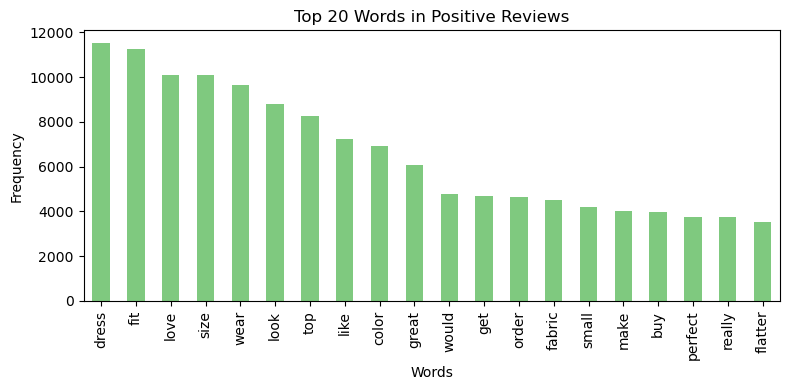

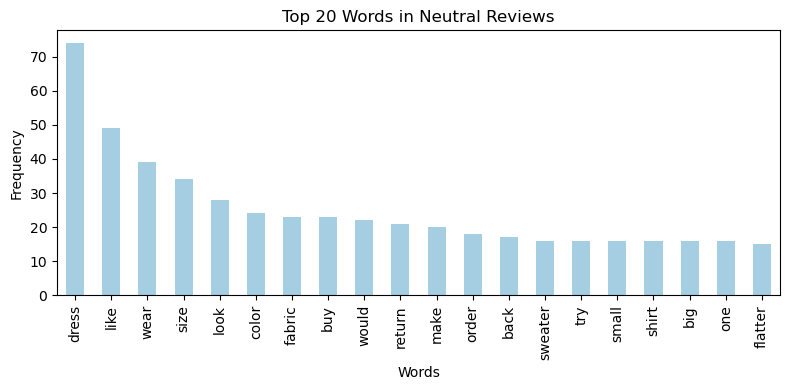

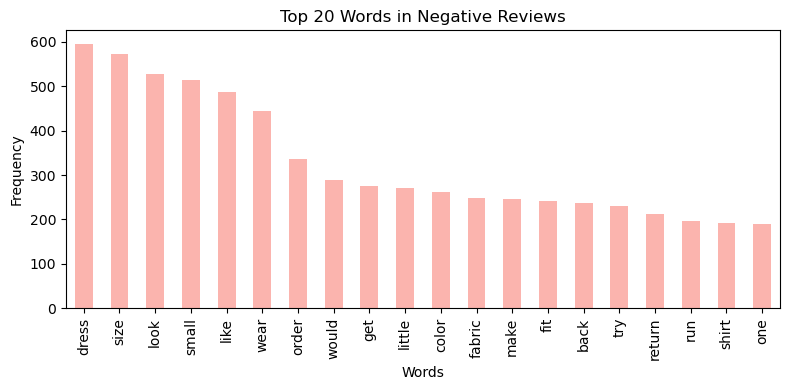

In [41]:
Positive = review_df[review_df['Sentiment_TextBlob']=='Positive']['Cleaned_Text']
Neutral = review_df[review_df['Sentiment_TextBlob']=='Neutral']['Cleaned_Text']
Negative = review_df[review_df['Sentiment_TextBlob']=='Negative']['Cleaned_Text']
colors = ['Accent', 'Paired', 'Pastel1']
splitedData = [Positive, Neutral, Negative]
sentiment_labels = ['Positive Reviews', 'Neutral Reviews', 'Negative Reviews']
for item in range(3):
    plt.figure(figsize=(8, 4))

    pd.Series(
        ' '.join(splitedData[item]).split()
    ).value_counts().head(20).plot(
        kind='bar',
        colormap=colors[item]
    )
    plt.title(f"Top 20 Words in {sentiment_labels[item]}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

### Text Visualization By Using Sentiment_VADER

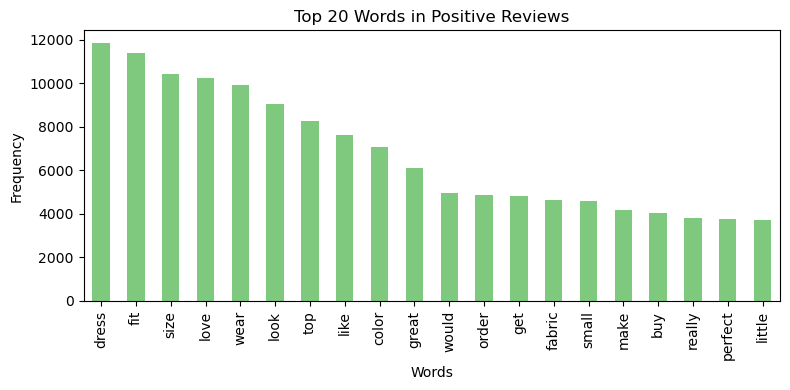

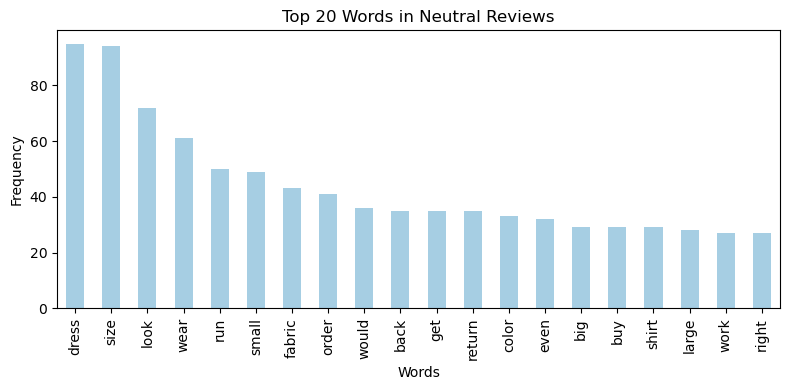

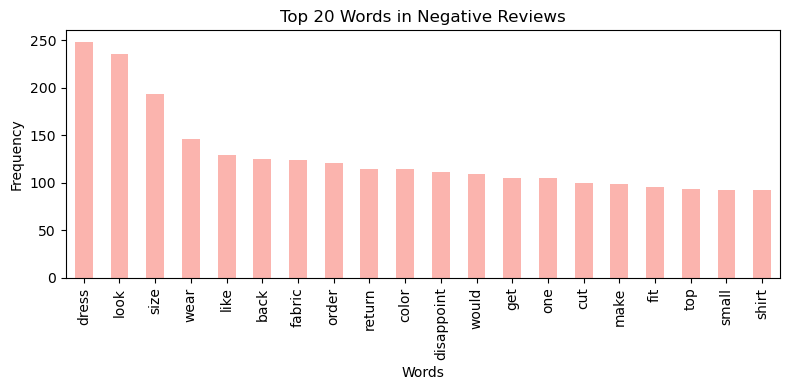

In [42]:
Positive = review_df[review_df['Sentiment_VADER']=='Positive']['Cleaned_Text']
Neutral = review_df[review_df['Sentiment_VADER']=='Neutral']['Cleaned_Text']
Negative = review_df[review_df['Sentiment_VADER']=='Negative']['Cleaned_Text']
colors = ['Accent', 'Paired', 'Pastel1']
splitedData = [Positive, Neutral, Negative]
for item in range(3):
    plt.figure(figsize=(8, 4))

    pd.Series(
        ' '.join(splitedData[item]).split()
    ).value_counts().head(20).plot(
        kind='bar',
        colormap=colors[item]
    )
    plt.title(f"Top 20 Words in {sentiment_labels[item]}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

## Extract Ratings and Correlate with Department Name column

In [43]:
# Filter for 4 and 5 star ratings only
high_rated_df = review_df[review_df['Rating'].isin([4, 5])].copy()

In [44]:
# Perform the Aggregation
category_analysis = high_rated_df.groupby('Department_Name').agg(
    Rating_Count=('Rating', 'count'),
    Average_Rating=('Rating', 'mean'),
    Five_Star_Count=('Rating', lambda x: (x == 5).sum()),
    Four_Star_Count=('Rating', lambda x: (x == 4).sum())
).sort_values('Rating_Count', ascending=False)

In [45]:
# Display the Data Table
print("High-Rated Category Performance & Rating:")
display(category_analysis)

High-Rated Category Performance & Rating:


,Rating_Count,Average_Rating,Five_Star_Count,Four_Star_Count
Department_Name,,,,
Tops,7652,4.711448,5444,2208
Dresses,4634,4.705006,3267,1367
Bottoms,2938,4.740640,2176,762
Intimate,1329,4.736644,979,350
Jackets,804,4.757463,609,195
Trend,78,4.666667,52,26


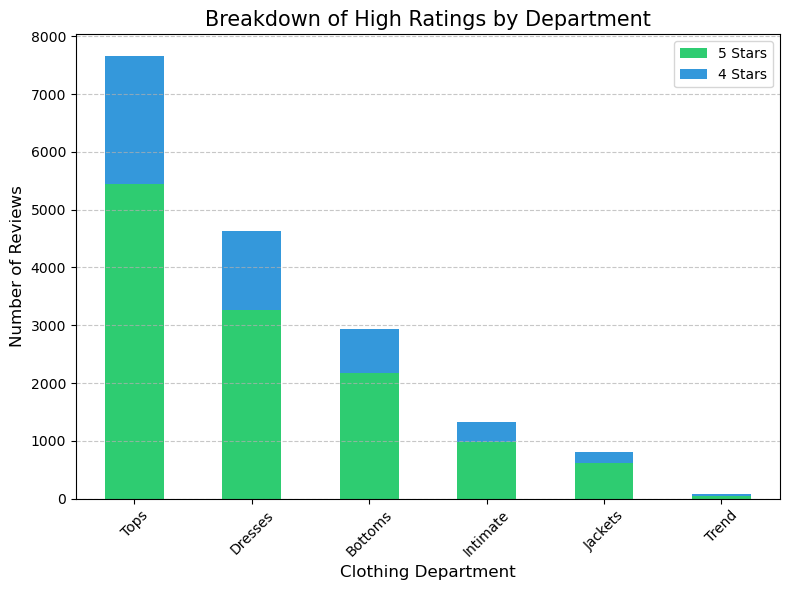

In [46]:
# Visualize: Stacked Bar Chart of 4 vs 5 Stars
import matplotlib.pyplot as plt

# Create a stacked bar chart
ax = category_analysis[['Five_Star_Count', 'Four_Star_Count']].plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 6),
    color=['#2ecc71', '#3498db'] # Green for 5, Blue for 4
)

plt.title('Breakdown of High Ratings by Department', fontsize=15)
plt.xlabel('Clothing Department', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(['5 Stars', '4 Stars'])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Generating data to be stored in MySQL database

In [47]:
# Calculate the 'Word Count' (Count of tokens in the processed text)
# This tells us how long the meaningful part of the review is
import json
review_df['Word_Count'] = review_df['Tokens_Clean'].apply(len)

# Serialize the Token List
# SQL cannot store a Python List directly (['a', 'b']). 
# We must convert it to a JSON string ("['a', 'b']") using json.dumps
review_df['Tokens_JSON'] = review_df['Tokens_Clean'].apply(json.dumps)

# Select and Order the columns exactly as we want them in the Database
final_export_df = review_df[[
    'Review_Text',          # Raw Review Text
    'Rating',               # Rating
    'Tokens_JSON',          # Segmented/Tokenized Data after removing stop words and words having length <=2
    'Sentiment_TextBlob',   # Sentiment Label (Positive/Negative)
    'Sentiment_VADER',      # Sentiment Label (Positive/Negative)
    'Word_Count'            # Count of words
]].copy()

# Preview the data to ensure it looks right before export
print("Data ready for Master Table export:")
display(final_export_df.head(3))

Data ready for Master Table export:


,Review_Text,Rating,Tokens_JSON,Sentiment_TextBlob,Sentiment_VADER,Word_Count
0,Absolutely wonderful - silky and sexy and comf...,4,"[""absolutely"", ""wonderful"", ""silky"", ""sexy"", ""...",Positive,Positive,5
1,Love this dress! it's sooo pretty. i happene...,5,"[""love"", ""dress"", ""sooo"", ""pretty"", ""happen"", ...",Positive,Positive,27
2,I had such high hopes for this dress and reall...,3,"[""high"", ""hop"", ""dress"", ""really"", ""want"", ""wo...",Positive,Positive,46


In [48]:
final_export_df.shape

(22641, 6)

In [49]:
# --- Define Connection Details and Connect ---
# host = "localhost"
# user = "my_mysql_user"         
# password = "my_mysql_password" 
# database = "my_database_name"  

import mysql.connector
from mysql.connector import Error
host = "localhost"
user= "root"
password = "MySQL@123"
database = "sentiment_analysis"

try:
    mydb = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )
    mycursor = mydb.cursor()
    print("MySQL connection established.")
except mysql.connector.Error as err:
    print(f"Error connecting to MySQL: {err}")
    # You might need to exit or handle the error gracefully here
    exit()

MySQL connection established.


In [50]:
print("final_export_df exists:", "final_export_df" in globals())

final_export_df exists: True


In [51]:
print("Connected:", mydb.is_connected())

table_name = "master_review_data_manual"

# ---  Create the Table (if it does not exist) ---
# Defining the column structure based on the final_export_df columns
create_table_sql = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    Review_Text TEXT,
    Rating INT,
    Tokens_JSON TEXT,
    Sentiment_TextBlob VARCHAR(50),
    Sentiment_VADER VARCHAR(50),
    Word_Count INT
)
"""
mycursor.execute(create_table_sql)
print(f"Table '{table_name}' checked/created.")

# ---  Defining the Insertion SQL Statement ---
# Use '%s' as placeholders for the data values.
cols = "(Review_Text, Rating, Tokens_JSON, Sentiment_TextBlob, Sentiment_VADER, Word_Count)"
sql_insert = f"INSERT INTO {table_name} {cols} VALUES (%s, %s, %s, %s, %s, %s)"

# Example: converting a pandas DataFrame to tuples
data_to_insert = [
    tuple(row)
    for row in final_export_df.itertuples(index=False, name=None)
]

# --- Execute the Bulk Insertion ---
try:
    # executemany efficiently sends all rows to the server
    mycursor.executemany(sql_insert, data_to_insert)
    mydb.commit()
    print(f"Success! {mycursor.rowcount} records inserted into '{table_name}'.")

except mysql.connector.Error as err:
    # If an error occurs (e.g., data type mismatch), roll back the changes
    mydb.rollback()
    print(f"Error during insertion: {err}")

# ---  Close Connection ---
mycursor.close()
mydb.close()

Connected: True
Table 'master_review_data_manual' checked/created.
Success! 22641 records inserted into 'master_review_data_manual'.
